In [24]:
#pip install pandas numpy statsmodels matplotlib

## libreria

In [25]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os


## carga bd

In [26]:
# 1. Load the dataset
ruta_relativa = "../../input/bacon_example.csv"
#file_path = "input/bacon_example.csv" 
df = pd.read_csv(ruta_relativa)

# browse data 
print(df.head())
print(df.columns)
output_path = "../output"

   stfips  year    _nfd  post      asmrs         pcinc     asmrh     cases  \
0       1  1964  1971.0     0  35.639885  12406.178537  5.007341  0.012312   
1       1  1965  1971.0     0  41.543755  13070.206738  4.425367  0.010419   
2       1  1966  1971.0     0  34.252335  13526.663217  4.874819  0.009900   
3       1  1967  1971.0     0  34.465023  13918.189823  5.362014  0.009975   
4       1  1968  1971.0     0  40.440105  14684.808682  4.643759  0.012401   

      weight         copop  
0  1715156.0  1.715156e+06  
1  1715156.0  1.725186e+06  
2  1715156.0  1.735219e+06  
3  1715156.0  1.745250e+06  
4  1715156.0  1.755283e+06  
Index(['stfips', 'year', '_nfd', 'post', 'asmrs', 'pcinc', 'asmrh', 'cases',
       'weight', 'copop'],
      dtype='object')


## parte a

In [ ]:
#  TWFE Regression -
formula_twfe = 'asmrs ~ post + pcinc + asmrh + cases + C(stfips) + C(year)'

# Fit the model
model_twfe = smf.ols(formula_twfe, data=df).fit()

# Calculate Clustered Standard Errors (Cluster by State)
twfe_results = model_twfe.get_robustcov_results(cov_type='cluster', groups=df['stfips'])


## part b


Event Time Frequency (Head and Tail):
event_time
-999.0    429
-17.0       2
-12.0       7
-7.0       32
-2.0       36
 3.0       36
 8.0       36
 13.0      34
 18.0      33
 23.0      24
Name: count, dtype: int64
Gráfico guardado en: ../output\histograma_frecuencias.png


C:\Users\johnb\AppData\Local\Temp\ipykernel_258524\2154416455.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


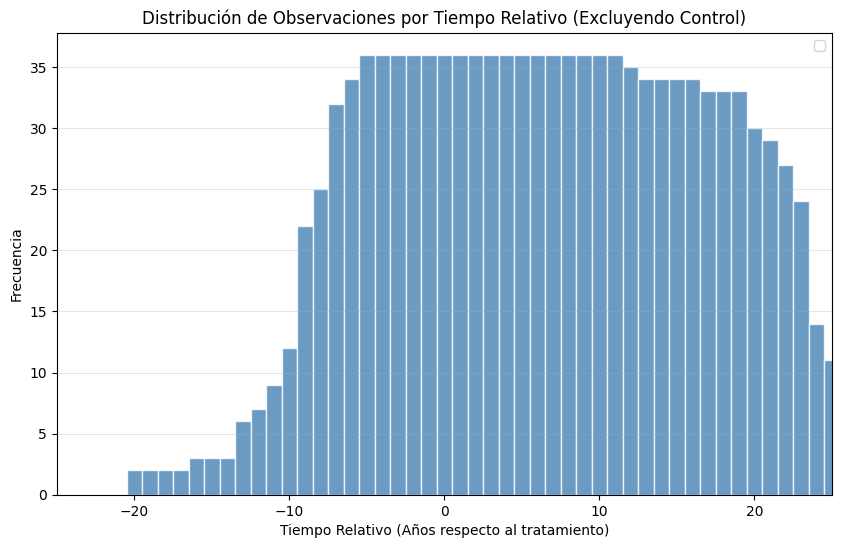


Relative time dummies created (Example): ['rel_neg8', 'rel_neg7', 'rel_neg6', 'rel_neg5', 'rel_neg4'] ...


In [ ]:
df['event_time'] = df['year'] - df['_nfd']

# Handle never-treated units (if _nfd is missing)
df['event_time'] = df['event_time'].fillna(-999) 

# 2. Descriptive summary
print("\nEvent Time Frequency (Head and Tail):")
print(df['event_time'].value_counts().sort_index().iloc[::5]) 


# Filtramos los -999 para que no rompan la escala del gráfico
plot_data = df[df['event_time'] != -999]

plt.figure(figsize=(10, 6))
# Creamos el histograma
plt.hist(plot_data['event_time'], bins=np.arange(plot_data['event_time'].min(), plot_data['event_time'].max()) + 0.5, 
         color='steelblue', edgecolor='white', alpha=0.8)


#plt.axvline(x=-8, color='red', linestyle='--', label='Lower Bound (-8)')
#plt.axvline(x=10, color='red', linestyle='--', label='Upper Bound (10)')

# Configuración del gráfico
plt.title('Distribución de Observaciones por Tiempo Relativo (Excluyendo Control)')
plt.xlabel('Tiempo Relativo (Años respecto al tratamiento)')
plt.ylabel('Frecuencia')
plt.xlim(-25, 25) # Limitamos el zoom visual al área de interés
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Guardar
hist_filename = os.path.join(output_path, "histograma_frecuencias.png")
plt.savefig(hist_filename, dpi=300, bbox_inches='tight')
print(f"Gráfico guardado en: {hist_filename}")

# Mostrar
plt.show()
plt.close() # 


# 3. Binning (Grouping extreme values)
# Justificación visual: Basado en el gráfico anterior, cortamos en -8 y 10.
lower_bound = -8
upper_bound = 10

# Create a new column for the binned time
df['rel_time_binned'] = df['event_time']

# Clip values at the bounds
# Usamos .loc para evitar advertencias de "SettingWithCopy"
df.loc[df['event_time'] < lower_bound, 'rel_time_binned'] = lower_bound
df.loc[df['event_time'] > upper_bound, 'rel_time_binned'] = upper_bound

# 4. Create relative-time dummy variables
# Generate list of sorted relative times within bounds
rel_times = sorted([k for k in df['rel_time_binned'].unique() 
                    if k >= lower_bound and k <= upper_bound])

# Create binary columns manually
dummies_list = []
for k in rel_times:
    # Formato seguro: -2 -> "rel_neg2", 0 -> "rel_0"
    suffix = str(int(k)).replace("-", "neg")
    col_name = f"rel_{suffix}"
    
    df[col_name] = (df['rel_time_binned'] == k).astype(int)
    dummies_list.append(col_name)

# Identify the reference category (usually t = -1)
ref_category = "rel_neg1"
if ref_category in dummies_list:
    dummies_list.remove(ref_category)

print(f"\nRelative time dummies created (Example): {dummies_list[:5]} ...")

 #### Question: Why do we usually group very distant event times together? 
 Its because we have thin support (less data) in the tails due to the finite sample window. Estimating separate coefficients for these sparse periods without binning would result in high standard errors and greater variance (low precision)


## part c

Estimando modelo... esto puede tardar unos segundos.
Tabla de coeficientes guardada en: ../output\event_study_coefs.csv
Gráfico guardado en: ../output\event_study_plot.png


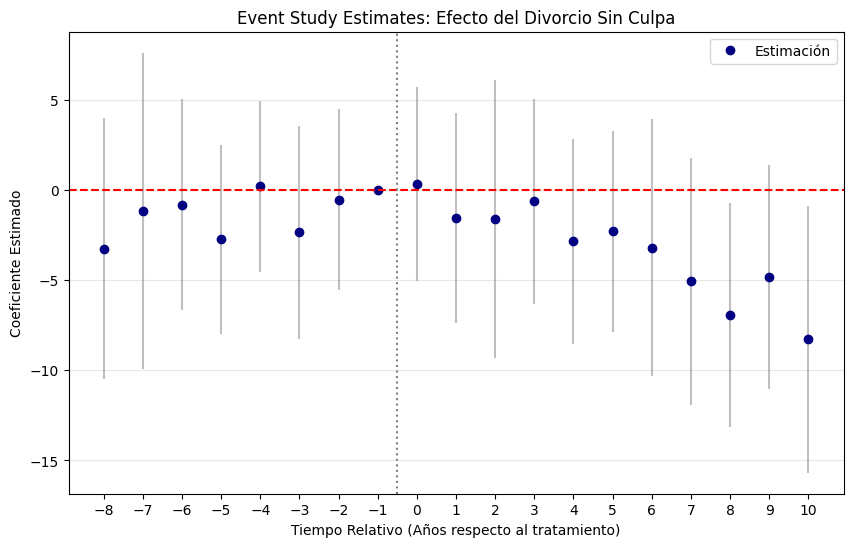

In [29]:
# 1. Estimar el modelo base
# Asumimos que 'dummies_list' y 'rel_times' vienen de la Parte B
# Construimos la fórmula: Outcome ~ Dummies + Controls + FEs
dummy_formula = " + ".join(dummies_list)

# Nota: C(stfips) y C(year) son efectos fijos de estado y año
formula_es = f"asmrs ~ {dummy_formula} + pcinc + asmrh + cases + C(stfips) + C(year)"

print("Estimando modelo... esto puede tardar unos segundos.")
model_es = smf.ols(formula_es, data=df).fit()

# 2. Calcular Errores Robustos (Clusterizados)
# Clusterizamos por 'stfips' (estado)
es_results = model_es.get_robustcov_results(cov_type='cluster', groups=df['stfips'])

# Convertimos params y bse a Series para facilitar la búsqueda por nombre
params_series = pd.Series(es_results.params, index=es_results.model.exog_names)
bse_series = pd.Series(es_results.bse, index=es_results.model.exog_names)

# 3. Almacenar coeficientes
coefs = []
bse = []
periods = []

# Definimos la categoría de referencia (asumimos t = -1 si no está definida)
# Asegúrate de que coincida con lo que excluiste en la Parte B
if 'ref_category' not in locals():
    ref_category = "rel_neg1" 

for k in rel_times:
    # Reconstruir nombre de la variable: e.g., -2 -> "rel_neg2", 0 -> "rel_0"
    suffix = str(int(k)).replace("-", "neg")
    col_name = f"rel_{suffix}"
    
    # Manejo de la categoría base (t=-1)
    if col_name == ref_category:
        coefs.append(0)
        bse.append(0)
    else:
        try:
            coefs.append(params_series[col_name])
            bse.append(bse_series[col_name])
        except KeyError:
            # Si no encuentra la variable, advertimos y ponemos NaN
            print(f"Advertencia: Variable {col_name} no encontrada.")
            coefs.append(np.nan)
            bse.append(np.nan)
    
    periods.append(k)

# 4. Crear DataFrame para resultados
res_df = pd.DataFrame({'period': periods, 'coef': coefs, 'se': bse})

# Calcular Intervalos de Confianza (95%)
res_df['ci_lower'] = res_df['coef'] - 1.96 * res_df['se']
res_df['ci_upper'] = res_df['coef'] + 1.96 * res_df['se']

# --- GUARDAR CSV (Resultados numéricos) ---
csv_filename = os.path.join(output_path, "event_study_coefs.csv")
res_df.to_csv(csv_filename, index=False)
print(f"Tabla de coeficientes guardada en: {csv_filename}")

# 5. Graficar y Guardar
plt.figure(figsize=(10, 6))

# Líneas de IC
plt.vlines(x=res_df['period'], ymin=res_df['ci_lower'], ymax=res_df['ci_upper'], color='grey', alpha=0.5)

# Puntos de coeficientes
plt.plot(res_df['period'], res_df['coef'], 'o', color='navy', label='Estimación')

# Línea base y momento del tratamiento
plt.axhline(y=0, color='red', linestyle='--')
plt.axvline(x=-0.5, color='grey', linestyle=':')

# Etiquetas
plt.title('Event Study Estimates: Efecto del Divorcio Sin Culpa')
plt.xlabel('Tiempo Relativo (Años respecto al tratamiento)')
plt.ylabel('Coeficiente Estimado')
plt.xticks(sorted(periods)) # Mostrar todos los ticks del eje X
plt.grid(True, axis='y', alpha=0.3)
plt.legend()

# --- GUARDAR PLOT (Imagen) ---
plot_filename = os.path.join(output_path, "event_study_plot.png")
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
print(f"Gráfico guardado en: {plot_filename}")

# Mostrar gráfico final
plt.show()